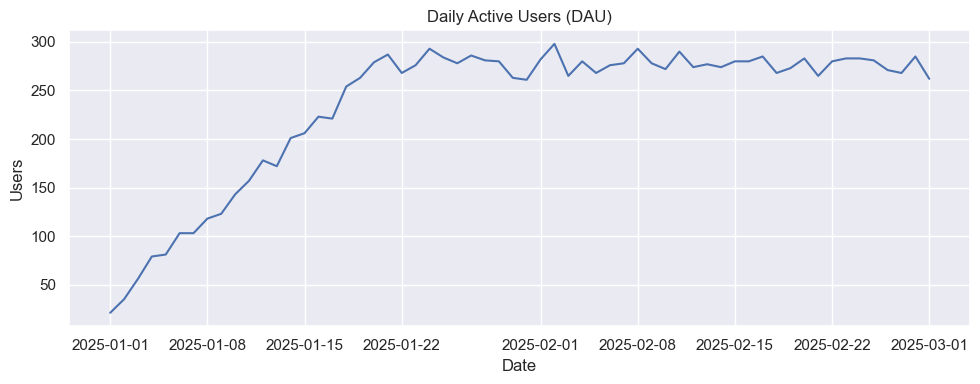

Retention rate (week1 -> last 2 weeks): 100.00%
Churn rate (week1 -> last 2 weeks):     0.00%


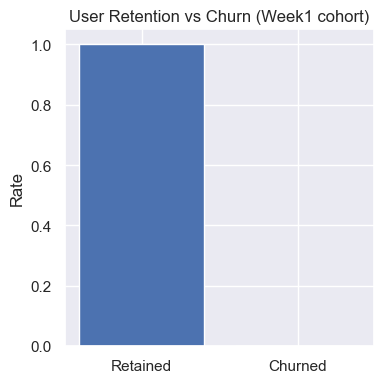

       total_sessions  avg_session_duration
count      500.000000            500.000000
mean        40.844000             10.075454
std          8.405294              0.828452
min         15.000000              7.613813
25%         35.000000              9.539851
50%         40.000000             10.050966
75%         46.000000             10.704046
max         76.000000             12.201147


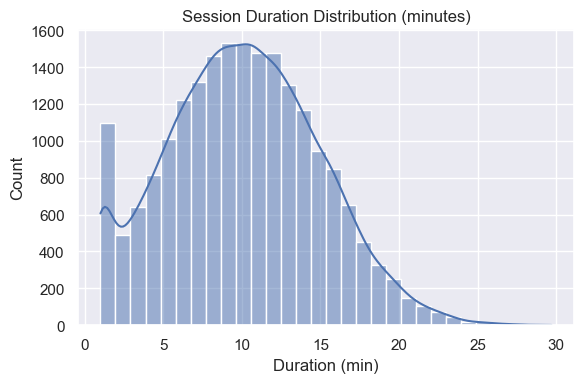

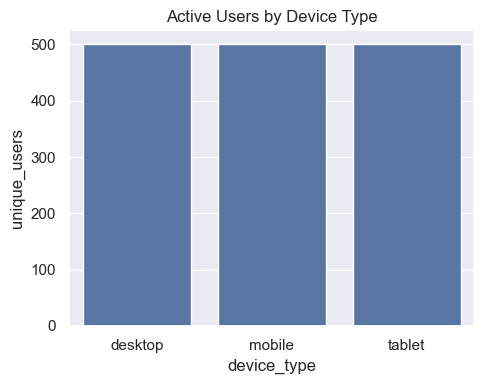

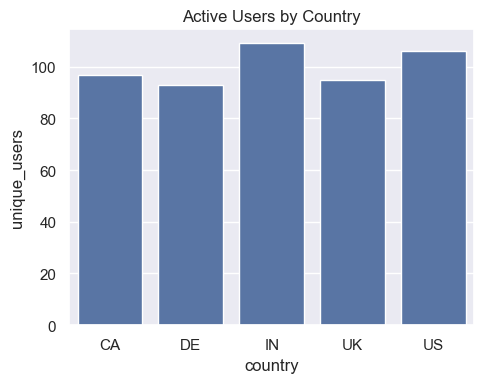

Key Insights:
- Average DAU over the period: 235.4 users.
- Retention from week 1 to the last two weeks is 100.0%, with churn at 0.0%.
- Users show different engagement levels by device and country; mobile usage appears strong.
- Session durations are centered around ~10 minutes with a long tail of longer sessions.


In [1]:
#  Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
np.random.seed(42)

#  Synthetic user session dataset
n_users = 500
n_days = 60

users = [f"user_{i}" for i in range(1, n_users + 1)]
countries = ["US", "CA", "UK", "DE", "IN"]
devices = ["mobile", "desktop", "tablet"]

signup_dates = pd.to_datetime("2025-01-01") + pd.to_timedelta(
    np.random.randint(0, 20, size=n_users), unit="D"
)
user_df = pd.DataFrame(
    {
        "user_id": users,
        "signup_date": signup_dates,
        "country": np.random.choice(countries, size=n_users),
        "device_preference": np.random.choice(devices, size=n_users),
    }
)

sessions_list = []
dates = pd.date_range("2025-01-01", periods=n_days, freq="D")

for _, row in user_df.iterrows():
    uid = row["user_id"]
    active_days = dates[dates >= row["signup_date"]]
    for day in active_days:
        n_sessions = np.random.poisson(lam=0.8)
        for _ in range(n_sessions):
            duration = max(1, np.random.normal(loc=10, scale=5))
            sessions_list.append(
                {
                    "user_id": uid,
                    "session_id": f"{uid}_{day.strftime('%Y%m%d')}_{np.random.randint(1e6)}",
                    "timestamp": day,
                    "session_duration_min": duration,
                    "device_type": np.random.choice(devices),
                    "country": row["country"],
                }
            )

sessions = pd.DataFrame(sessions_list)
sessions.head()

#  Basic cleaning and feature engineering
sessions["date"] = pd.to_datetime(sessions["timestamp"]).dt.date
sessions["date"] = pd.to_datetime(sessions["date"])

# sessions per user per day
daily_user_activity = (
    sessions.groupby(["date", "user_id"])["session_id"]
    .nunique()
    .reset_index(name="sessions_per_user_day")
)

#  DAU / WAU / MAU
dau = (
    daily_user_activity.groupby("date")["user_id"]
    .nunique()
    .reset_index(name="DAU")
)

dau["week"] = dau["date"].dt.to_period("W").apply(lambda r: r.start_time)
wau = dau.groupby("week")["DAU"].sum().reset_index(name="WAU")

dau["month"] = dau["date"].dt.to_period("M").apply(lambda r: r.start_time)
mau = dau.groupby("month")["DAU"].sum().reset_index(name="MAU")

#  Plot DAU
plt.figure(figsize=(10, 4))
plt.plot(dau["date"], dau["DAU"])
plt.title("Daily Active Users (DAU)")
plt.xlabel("Date")
plt.ylabel("Users")
plt.tight_layout()
plt.show()

#  Retention & churn (simple cohort-style)

# First week and last two weeks windows
start_week = dau["date"].min() + pd.to_timedelta(6, unit="D")
end_period_start = dau["date"].max() - pd.to_timedelta(13, unit="D")

week1_users = set(
    daily_user_activity[daily_user_activity["date"] <= start_week]["user_id"]
)

last_two_weeks_users = set(
    daily_user_activity[daily_user_activity["date"] >= end_period_start]["user_id"]
)

retained_users = week1_users & last_two_weeks_users
churned_users = week1_users - last_two_weeks_users

retention_rate = len(retained_users) / len(week1_users) if week1_users else 0
churn_rate = len(churned_users) / len(week1_users) if week1_users else 0

print(f"Retention rate (week1 -> last 2 weeks): {retention_rate:.2%}")
print(f"Churn rate (week1 -> last 2 weeks):     {churn_rate:.2%}")

#  Simple retention vs churn bar chart
plt.figure(figsize=(4, 4))
plt.bar(["Retained", "Churned"], [retention_rate, churn_rate])
plt.title("User Retention vs Churn (Week1 cohort)")
plt.ylabel("Rate")
plt.tight_layout()
plt.show()

#  Session-level metrics
session_metrics = sessions.groupby("user_id").agg(
    total_sessions=("session_id", "nunique"),
    avg_session_duration=("session_duration_min", "mean"),
)

print(session_metrics.describe())

#  Session duration distribution
plt.figure(figsize=(6, 4))
sns.histplot(sessions["session_duration_min"], bins=30, kde=True)
plt.title("Session Duration Distribution (minutes)")
plt.xlabel("Duration (min)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#  Device and country breakdown
device_usage = (
    sessions.groupby("device_type")["user_id"]
    .nunique()
    .reset_index(name="unique_users")
)
country_usage = (
    sessions.groupby("country")["user_id"]
    .nunique()
    .reset_index(name="unique_users")
)

plt.figure(figsize=(5, 4))
sns.barplot(data=device_usage, x="device_type", y="unique_users")
plt.title("Active Users by Device Type")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
sns.barplot(data=country_usage, x="country", y="unique_users")
plt.title("Active Users by Country")
plt.tight_layout()
plt.show()

#  Simple text insights
print("Key Insights:")
print(f"- Average DAU over the period: {dau['DAU'].mean():.1f} users.")
print(
    f"- Retention from week 1 to the last two weeks is {retention_rate:.1%}, "
    f"with churn at {churn_rate:.1%}."
)
print(
    "- Users show different engagement levels by device and country; mobile usage appears strong."
)
print(
    "- Session durations are centered around ~10 minutes with a long tail of longer sessions."
)
